<a href="https://colab.research.google.com/github/SibaIssa/Decorators-in-Action/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset:**

In [ ]:
!wget http://ftp.itec.aau.at/datasets/LapGyn4/LapGyn4_v1.2.zip

In [ ]:
!sudo apt install unzip
!unzip LapGyn4_v1.2.zip

In [ ]:
#data_dir = 'LapGyn4_v1.2'
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


# **Image Preprocessing:**

## **Noise Reduction:**

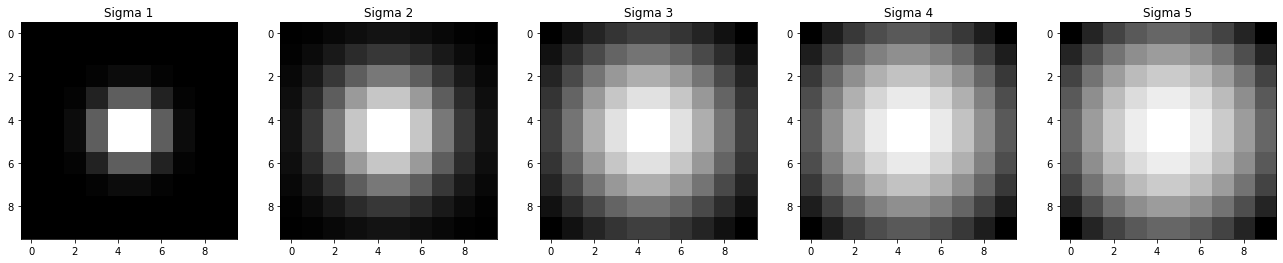

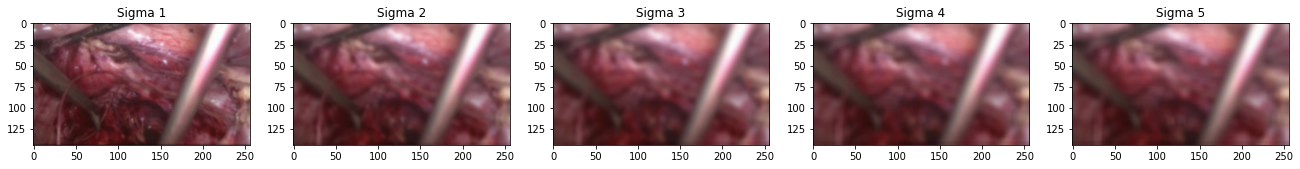

In [ ]:
# Import libraries
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
# set inline plots size
plt.rcParams["figure.figsize"] = (22.5, 10.5) # (w, h)
import numpy as np
import cv2


def showInRow(list_of_images, titles = None):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
  plt.show()
  

image_bgr = cv2.imread("/content/c_4_v_55_f_2203.jpg", cv2.IMREAD_COLOR)
image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY) 
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


def getGaussKernel2d(ksize, sigma):
  kern = cv2.getGaussianKernel(ksize, sigma)
  return kern * np.transpose(kern)

max_sigma = 6
kernels = list(map(lambda x: getGaussKernel2d(10, x), range(1, max_sigma)))
kernels_titles = list(map(lambda x: "Sigma "+str(x), range(1, max_sigma)))

image_rgb_small = cv2.resize(image_rgb, None, fx=.4, fy=.4, interpolation = cv2.INTER_CUBIC)
image = list(map(lambda kern: cv2.filter2D(image_rgb_small, -1, kern), kernels))
# cv2.filter2D(): Convolves an image with the kernel.

showInRow(kernels, kernels_titles)
showInRow(image, kernels_titles)

## **Histogram Equalization:**

Histogram type is: <class 'numpy.ndarray'>
Histogram shape is: (256, 1)


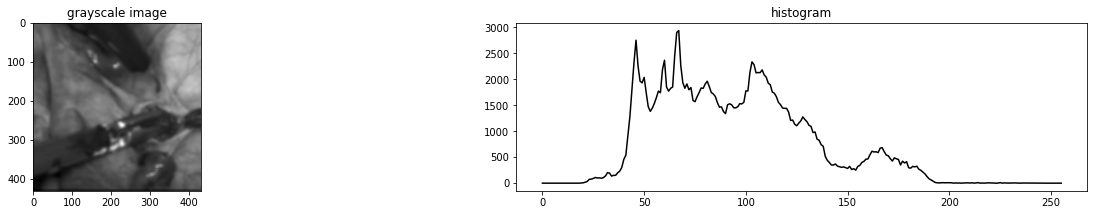

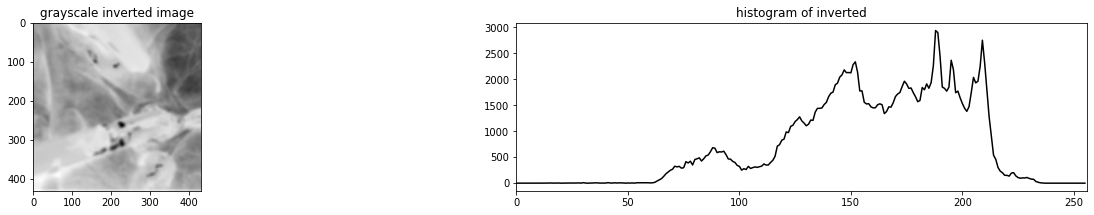

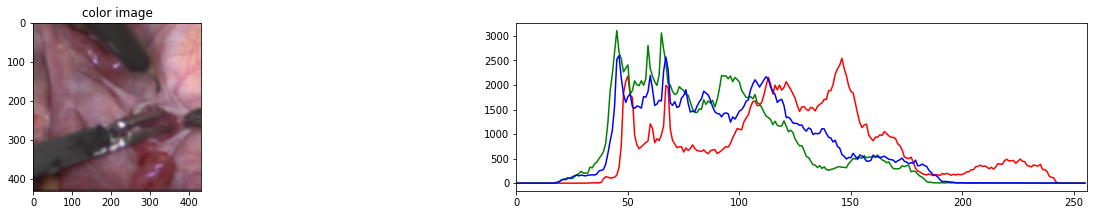

In [ ]:
import cv2 as cv
import numpy as np
img = image[4]
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

equ = cv.equalizeHist(gray)
res = equ #stacking images side-by-side
cv.imwrite('res.jpg',res)

# plot image
plt.subplot(3,2,1)
plt.imshow(gray, cmap = 'gray')
plt.title('grayscale image')

# calculate histogram
hist = cv2.calcHist([gray],[0],None,[256],[0,255])
print('Histogram type is: {}'.format(type(hist)))
print('Histogram shape is: {}'.format(hist.shape))

# plot histogram
plt.subplot(3,2,2)
plt.plot(hist,color = 'black')
plt.title('histogram')
#plt.xlim([0,256])
plt.show()

# plot inversed histogram
image_gray_inv = cv2.bitwise_not(gray)
hist_inv = cv2.calcHist([image_gray_inv],[0],None,[256],[0,255])
plt.subplot(3,2,3)
plt.imshow(image_gray_inv, cmap = 'gray')
plt.title('grayscale inverted image')
#plt.xticks([]),plt.yticks([])

plt.subplot(3,2,4)
plt.plot(hist_inv,color = 'black')
plt.title('histogram of inverted')
plt.xlim([0,256])
plt.show()


plt.subplot(3,2,5)
plt.imshow(image[4])
plt.title('color image')
#plt.xticks([]),plt.yticks([])

plt.subplot(3,2,6)
color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv2.calcHist([image[4]],[i],None,[256],[0,255])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()



## **Color Segmentation:**

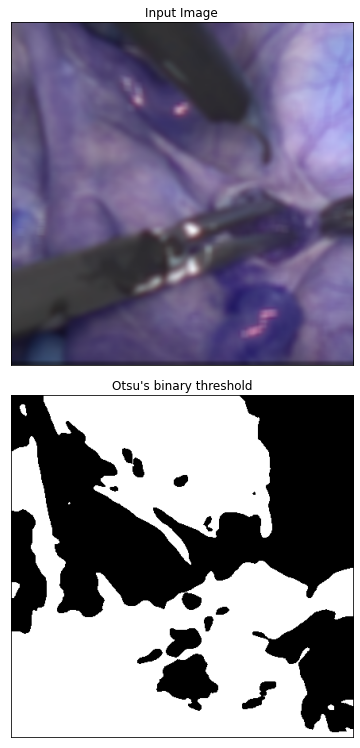

In [ ]:
# SEGMENTATION
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = image[4]
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.subplot(211),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(thresh, 'gray')
plt.imsave(r'thresh.png',thresh)
plt.title("Otsu's binary threshold"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

# **Hough Transformation:**

In [ ]:
# all plots will be displayed directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time, cv2, math
from typing import AnyStr, Any, Callable

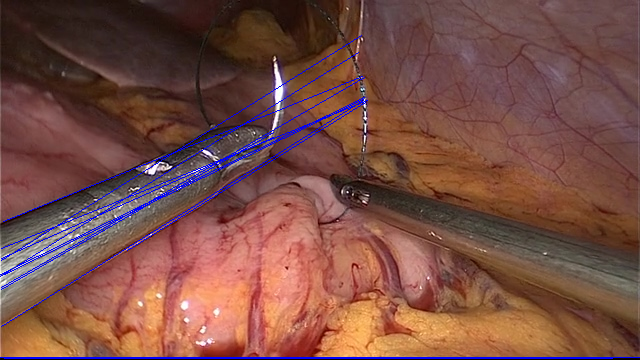

In [46]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/c_101_v_3087_f_3454.jpg', cv2.IMREAD_COLOR)
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Find the edges in the image using canny detector
edges = cv2.Canny(gray, 190, 200)
# Detect points that form a line
lines = cv2.HoughLinesP(edges, 1, np.pi/90, 70, minLineLength=10, maxLineGap=250)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
# Show result
cv2_imshow(img)